# AutoML алгоритмы для работы с данными

## Импорт модулей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    root_mean_squared_error,
)

import h2o
from h2o.automl import H2OAutoML
from pycaret.time_series import setup, compare_models, predict_model, save_model

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Задача1. Классификация

## Константы

In [2]:
TRAIN_PATH = "../Lesson38/smoking_data/train_dataset.csv"
TARGET = "smoking"
RANDOM_STATE = 777
TEST_SIZE = 0.2

## Загрузка данных

In [3]:
df = pd.read_csv(TRAIN_PATH)

print("Train DataFrame")
df.head()

Train DataFrame


,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,35,170,85,97.0,0.9,0.9,1,1,118,78,...,70,142,19.8,1,1.0,61,115,125,1,1
1,20,175,110,110.0,0.7,0.9,1,1,119,79,...,71,114,15.9,1,1.1,19,25,30,1,0
2,45,155,65,86.0,0.9,0.9,1,1,110,80,...,57,112,13.7,3,0.6,1090,1400,276,0,0
3,45,165,80,94.0,0.8,0.7,1,1,158,88,...,46,91,16.9,1,0.9,32,36,36,0,0
4,20,165,60,81.0,1.5,0.1,1,1,109,64,...,47,92,14.9,1,1.2,26,28,15,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin           38984 non-null 

## Исследовательский анализ данных

Проверка дубликатов.

In [5]:
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 5517


Удаление дубликатов.

In [6]:
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


In [7]:
def numeric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Минимум"] = df.min().round(2)
    stats["Максимум"] = df.max().round(2)
    stats["Среднее"] = df.mean().round(2)
    stats["Медиана"] = df.median().round(2)
    stats["Дисперсия"] = df.var().round(2)
    stats["Квантиль 0.1"] = df.quantile(0.1).round(2)
    stats["Квантиль 0.9"] = df.quantile(0.9).round(2)
    stats["Квартиль 1"] = df.quantile(0.25).round(2)
    stats["Квартиль 3"] = df.quantile(0.75).round(2)

    return stats

In [8]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df)

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
age,0.0,20.0,85.0,44.15,40.0,145.73,30.0,60.0,40.0,55.0
height(cm),0.0,130.0,190.0,164.68,165.0,84.56,150.0,175.0,160.0,170.0
weight(kg),0.0,30.0,135.0,65.93,65.0,165.84,50.0,85.0,55.0,75.0
waist(cm),0.0,51.0,129.0,82.08,82.0,86.69,70.0,94.0,76.0,88.0
eyesight(left),0.0,0.1,9.9,1.01,1.0,0.25,0.6,1.5,0.8,1.2
eyesight(right),0.0,0.1,9.9,1.01,1.0,0.25,0.6,1.5,0.8,1.2
hearing(left),0.0,1.0,2.0,1.03,1.0,0.02,1.0,1.0,1.0,1.0
hearing(right),0.0,1.0,2.0,1.03,1.0,0.03,1.0,1.0,1.0,1.0
systolic,0.0,71.0,233.0,121.50,120.0,186.90,104.0,138.0,112.0,130.0
relaxation,0.0,40.0,146.0,76.02,76.0,93.55,64.0,88.0,70.0,82.0


Данные не содержат пропущенные значения и имеют различный масштаб.

## Подготовка датасета к построению моделей ML

### Распределение целевой переменной

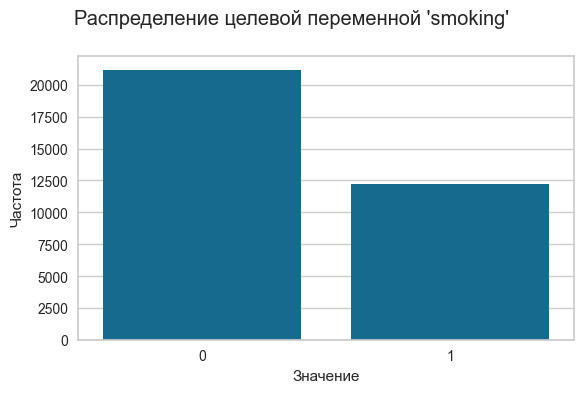

In [9]:
# Визуализация распределения целевой переменной
fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(df[TARGET].value_counts(), ax=ax)
ax.set_xlabel("Значение")
ax.set_ylabel("Частота")

plt.suptitle(f"Распределение целевой переменной '{TARGET}'")
plt.tight_layout()
plt.show()

В распределении целевого признака преобладает доля некурящих людей.

### Распределение числовых переменных

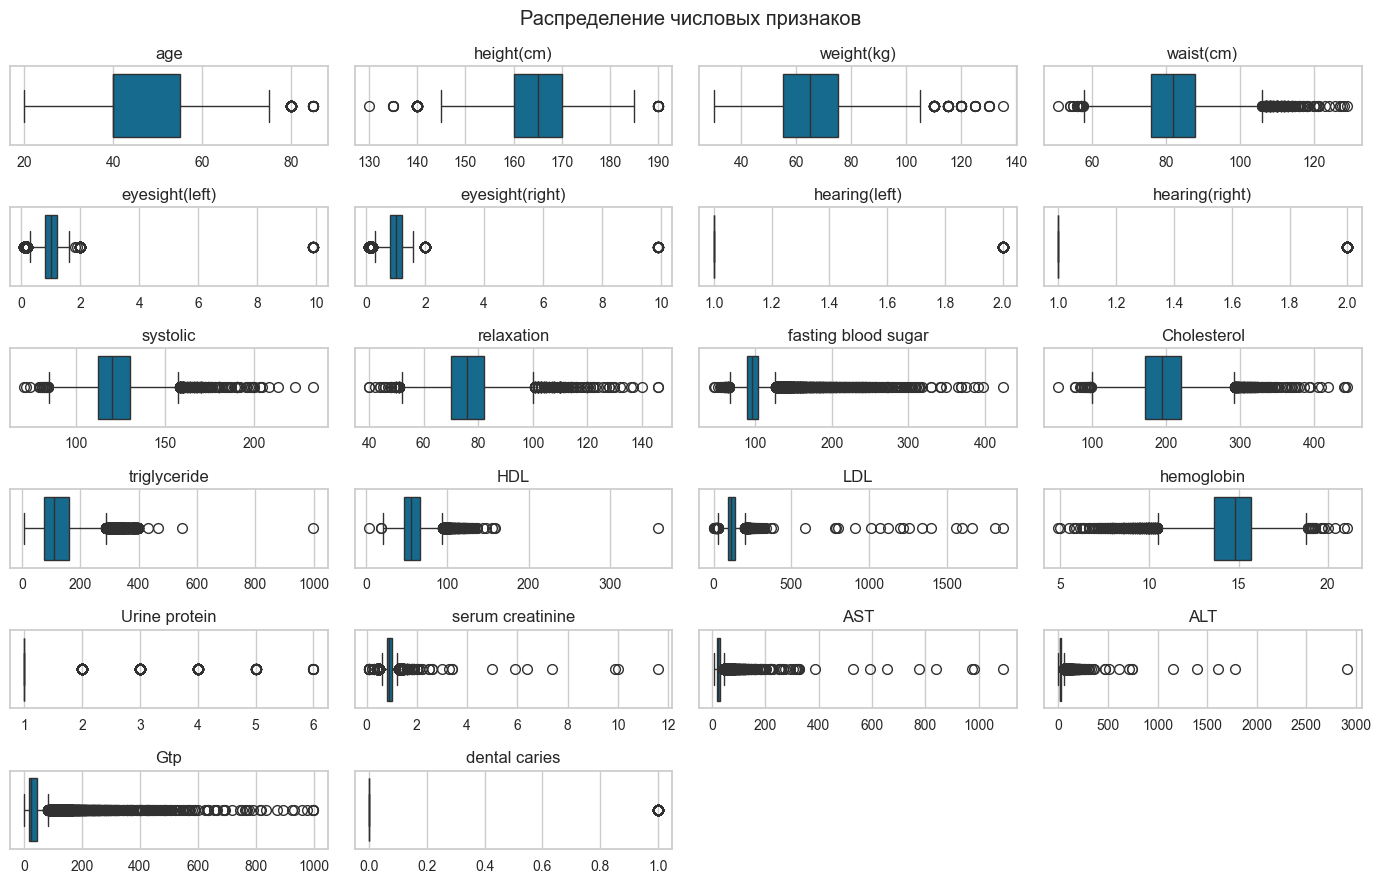

In [10]:
fig, ax = plt.subplots(6, 4, figsize=(14, 9))

for i, col in enumerate([col for col in df.columns if col != TARGET]):
    row_idx, col_idx = divmod(i, 4)
    sns.boxplot(df[col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

for i in range(len(df.columns) - 1, len(ax.flatten())):
    fig.delaxes(ax.flatten()[i])

plt.suptitle("Распределение числовых признаков")
plt.tight_layout()
plt.show()

Можно видеть, что числовые переменные имеют широкие диапазоны изменений, которые нельзя однозначно отнести к выбросам, оставим признаки без изменений.

### Построение информативных графиков

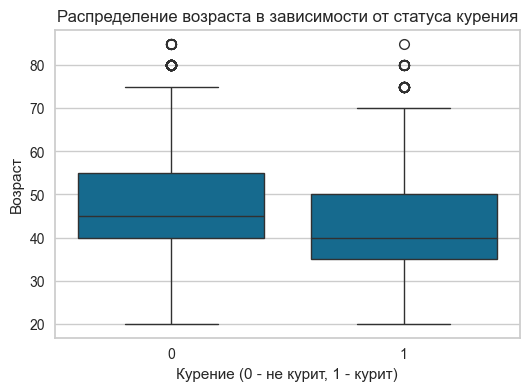

In [11]:
# Зависимости возраста от статуса курения
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["smoking"], y=df["age"])
plt.title("Распределение возраста в зависимости от статуса курения")
plt.xlabel("Курение (0 - не курит, 1 - курит)")
plt.ylabel("Возраст")
plt.show()

Можно видеть, что отказ от курения немного увеличивает продолжительность жизни.

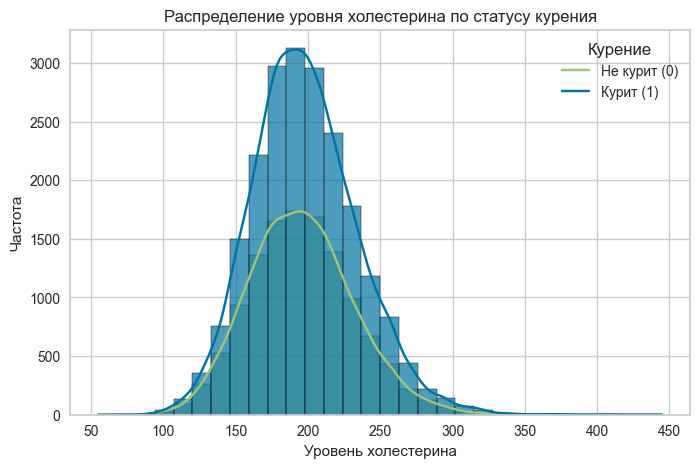

In [12]:
# Распределение уровня холестерина в зависимости от статуса курения
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="Cholesterol", hue="smoking", kde=True, bins=30, alpha=0.7)
plt.title("Распределение уровня холестерина по статусу курения")
plt.xlabel("Уровень холестерина")
plt.ylabel("Частота")
plt.legend(title="Курение", labels=["Не курит (0)", "Курит (1)"])
plt.show()

Факт курения практически не влияет на уровень холестерина.

### Анализ корреляций

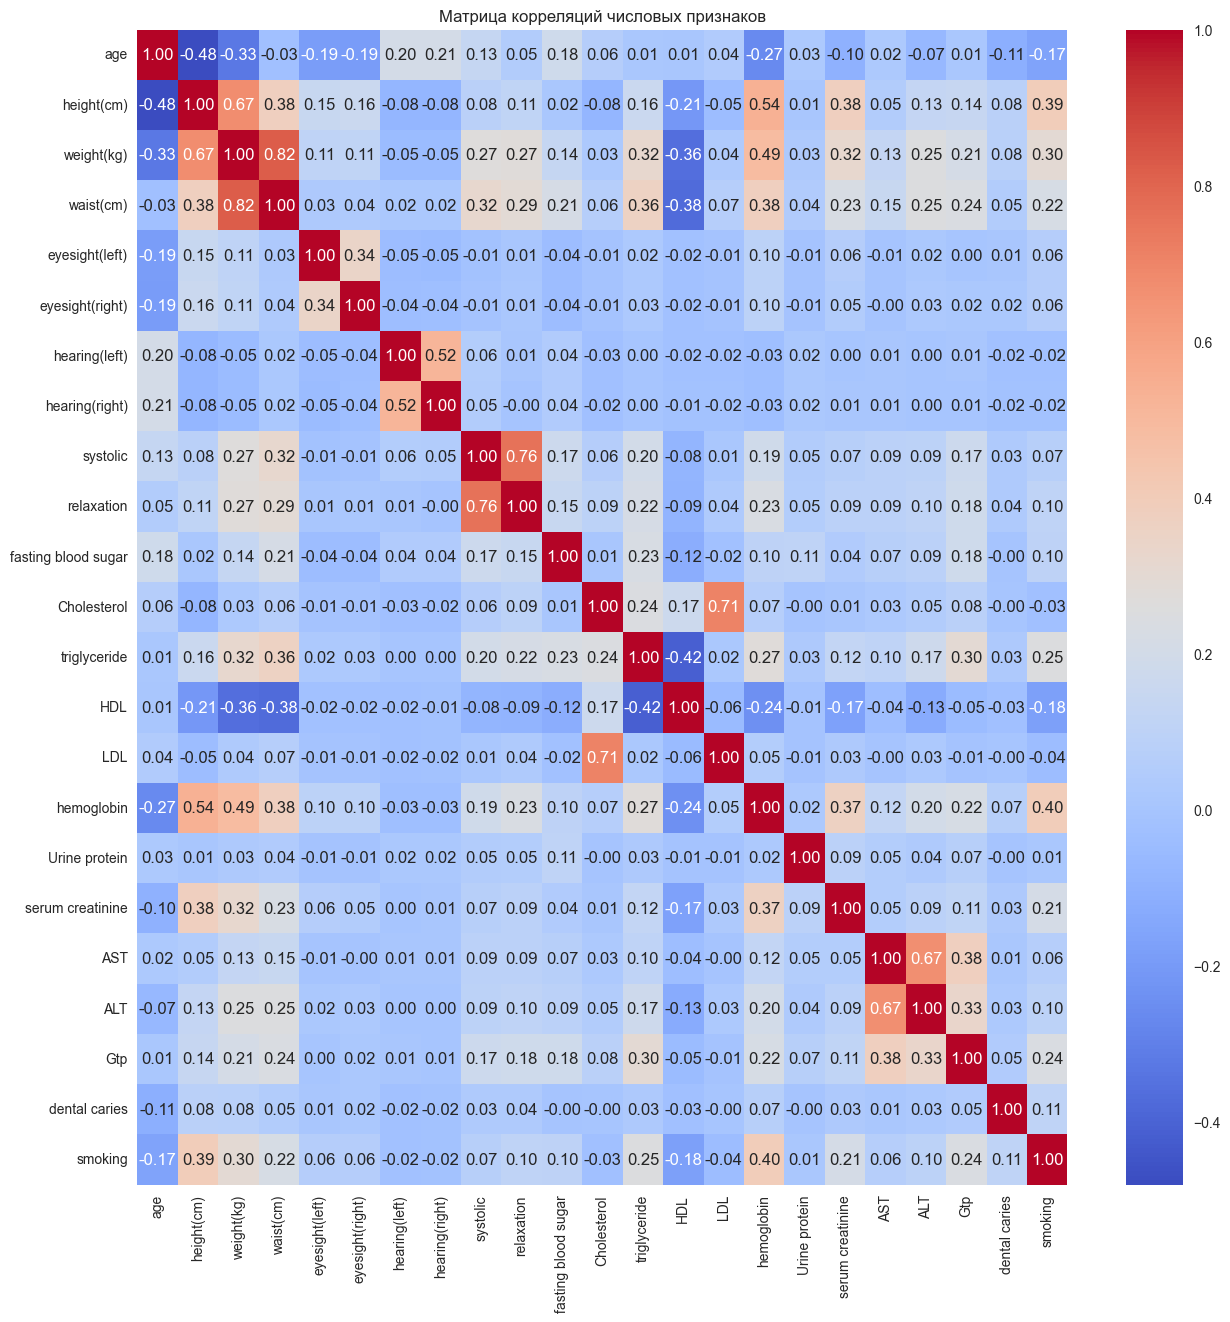

In [13]:
# Матрица корреляций
plt.figure(figsize=(15, 15))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций числовых признаков")
plt.show()

В данных присутствуют ожидаемые корреляции между height-weight, weight-weist, ALT-AST, Cholesterol-LDL, relaxation-systolic, hearing(left)-hearing(right). Оставим данные без изменений.

## Применение инструментов AutoML

In [14]:
# Инициализация H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-11.0.26+4 (build 11.0.26+4, mixed mode)
  Starting server from C:\Users\ivana\miniconda3\envs\acoustic_env\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ivana\AppData\Local\Temp\tmpyq4mho36
  JVM stdout: C:\Users\ivana\AppData\Local\Temp\tmpyq4mho36\h2o_ivana_started_from_python.out
  JVM stderr: C:\Users\ivana\AppData\Local\Temp\tmpyq4mho36\h2o_ivana_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Yekaterinburg
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_ivana_elyk12
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.943 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [15]:
# Разделение данных
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print(f"X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
print(f"X_test.shape={X_test.shape}, y_test.shape={y_test.shape}\n")

print(f"X_train_scaled.shape={X_train_scaled.shape}")
print(f"X_test_scaled.shape={X_test_scaled.shape}")

X_train.shape=(26773, 22), y_train.shape=(26773,)
X_test.shape=(6694, 22), y_test.shape=(6694,)

X_train_scaled.shape=(26773, 22)
X_test_scaled.shape=(6694, 22)


In [16]:
# Преобразование данных в формат H2O
features = [col for col in df.columns if col != TARGET]

df_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
df_train_scaled = pd.concat(
    [df_train_scaled, pd.DataFrame(y_train, columns=[TARGET])], axis=1
)

df_test_scaled = pd.DataFrame(X_test_scaled, columns=features)

h2o_train_scaled = h2o.H2OFrame(df_train_scaled)
h2o_train_scaled[TARGET] = h2o_train_scaled[TARGET].asfactor()

h2o_test_scaled = h2o.H2OFrame(df_test_scaled)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [17]:
# Запуск AutoML
aml = H2OAutoML(max_models=10, seed=RANDOM_STATE)
aml.train(y=TARGET, x=features, training_frame=h2o_train_scaled)
h2o.display.toggle_user_tips()

AutoML progress: |
18:41:17.980: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


In [18]:
# Просмотр результатов
lb = aml.leaderboard
lb.head(rows=5)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20250406_184117,0.833201,0.473337,0.707853,0.244619,0.398489,0.158794
StackedEnsemble_BestOfFamily_1_AutoML_1_20250406_184117,0.832237,0.474132,0.706092,0.245673,0.398954,0.159164
GBM_grid_1_AutoML_1_20250406_184117_model_1,0.830945,0.476277,0.703573,0.244118,0.399796,0.159837
GBM_5_AutoML_1_20250406_184117,0.829519,0.478197,0.701705,0.248089,0.400581,0.160465
GBM_1_AutoML_1_20250406_184117,0.829463,0.477979,0.700528,0.247587,0.400763,0.160611


Наибольшей точностью обладает ансамбль моделей, объединяющий предсказания моделей.

In [19]:
# Получение предсказаний модели AutoML
aml_model = aml.leader
y_prob_aml = aml_model.predict(h2o_test_scaled)["p1"]

y_prob_aml = y_prob_aml.as_data_frame(use_multi_thread=True)
y_prob_aml = y_prob_aml.values.flatten()

y_pred_aml = y_prob_aml.round().astype("int")

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


### Оценка качества моделей

In [20]:
def get_metrics(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    return accuracy, precision, recall, f1, roc_auc


# Сравнительная таблица качества моделей
quality_comparison = pd.DataFrame(
    {
        "Metrics": ["accuracy", "precision", "recall", "f1", "roc_auc"],
        "AutoML": [
            *map(lambda x: round(x, 2), get_metrics(y_test, y_pred_aml, y_prob_aml))
        ],
        "GradientBoostingClassifier": [0.75, 0.67, 0.65, 0.66, 0.83],
        "RandomForestClassifier": [0.75, 0.66, 0.64, 0.65, 0.83],
        "LogisticRegression": [0.69, 0.57, 0.69, 0.63, 0.77],
        "DecisionTreeClassifier": [0.72, 0.62, 0.62, 0.62, 0.79],
        "SVC": [0.74, 0.66, 0.62, 0.64, 0.82],
    }
)

quality_comparison

,Metrics,AutoML,GradientBoostingClassifier,RandomForestClassifier,LogisticRegression,DecisionTreeClassifier,SVC
0,accuracy,0.75,0.75,0.75,0.69,0.72,0.74
1,precision,0.67,0.67,0.66,0.57,0.62,0.66
2,recall,0.66,0.65,0.64,0.69,0.62,0.62
3,f1,0.67,0.66,0.65,0.63,0.62,0.64
4,roc_auc,0.83,0.83,0.83,0.77,0.79,0.82


Качество модели AutoML находится на уровне градиентного бустинга, достигнутого ранее.

In [21]:
# Сохранение модели AutoML
h2o.save_model(model=aml_model, path="./aml_models/", force=True)

'C:\\Users\\ivana\\MLInnopolis\\Module3\\Lesson54\\aml_models\\StackedEnsemble_AllModels_1_AutoML_1_20250406_184117'

# Задача 2. Прогнозирование временных рядов

## Загрузка данных

In [22]:
df = pd.read_csv("../Lesson49/milk-production.csv")

df = df.drop(columns=["Unnamed: 0"])
df = df.rename(columns={"Monthly milk production (pounds per cow)": "milk_production"})

df["Month"] = pd.to_datetime(df["Month"], format="%Y-%m")
df["Month"] = df["Month"].dt.strftime("%Y-%m")
df = df.set_index("Month")

print(df.head(), end="\n\n")
df.info()

         milk_production
Month                   
1962-01              589
1962-02              561
1962-03              640
1962-04              656
1962-05              727

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 1962-01 to 1975-12
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   milk_production  168 non-null    int64
dtypes: int64(1)
memory usage: 2.6+ KB


## Разведочный анализ данных

In [23]:
# Статистическое описание данных
print(df.describe())

       milk_production
count       168.000000
mean        754.708333
std         102.204524
min         553.000000
25%         677.750000
50%         761.000000
75%         824.500000
max         969.000000


In [24]:
# Проверка пропущенных значений
print(df.isnull().sum())

milk_production    0
dtype: int64


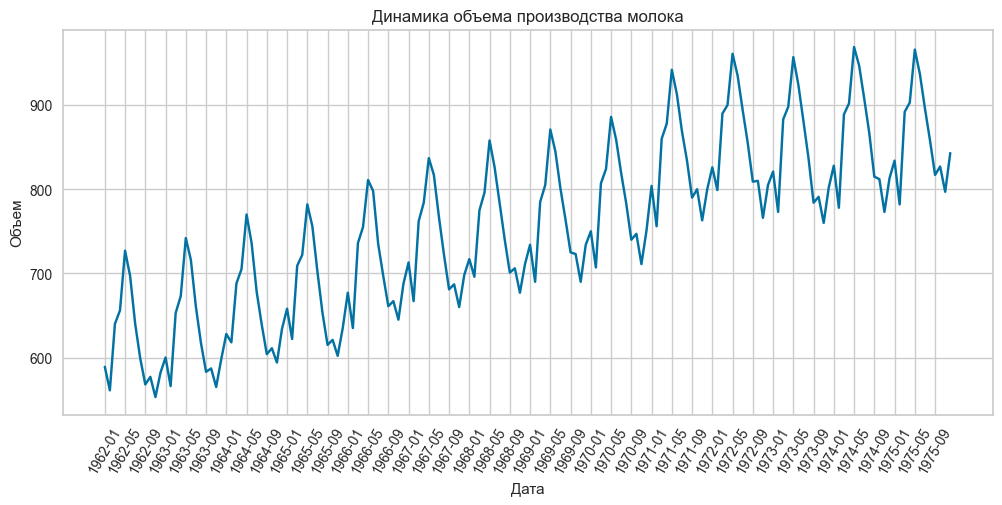

In [25]:
# Визуализация временного ряда
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["milk_production"])
plt.xlabel("Дата")
plt.ylabel("Объем")
plt.xticks(
    df.index[::4],
    rotation=60,
)
plt.title("Динамика объема производства молока")
plt.show()

- Данные идут непрерывно с начала 1962 года по конец 1975 года
- Видим общий тренд к росту: с 600 до 900
- Заметны регулярные колебания в течение каждого года

##  Анализ временного ряда

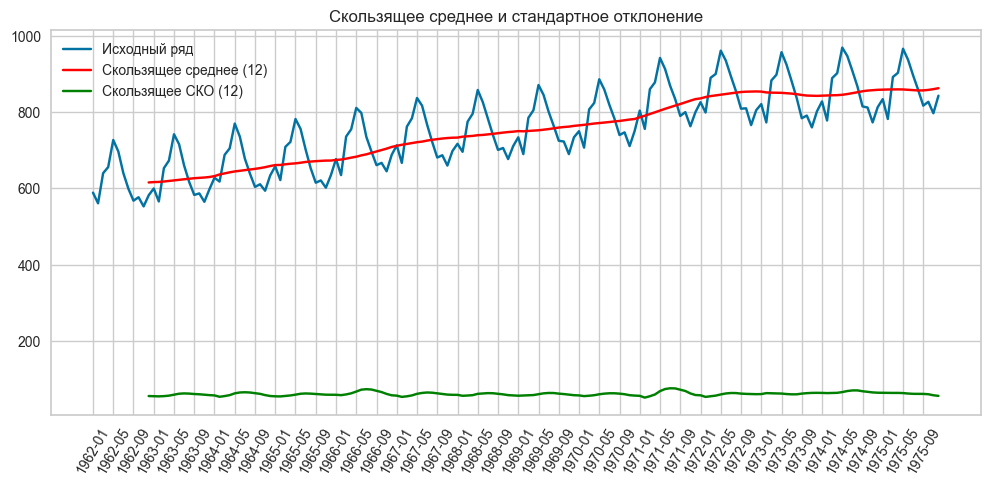

In [26]:
# Скользящее среднее и скользящее стандартное отклонение
rolling_mean = df["milk_production"].rolling(window=12).mean()
rolling_std = df["milk_production"].rolling(window=12).std()

plt.figure(figsize=(12, 5))
plt.plot(df["milk_production"], label="Исходный ряд")
plt.plot(rolling_mean, color="red", label="Скользящее среднее (12)")
plt.plot(rolling_std, color="green", label="Скользящее СКО (12)")
plt.title("Скользящее среднее и стандартное отклонение")
plt.xticks(
    df.index[::4],
    rotation=60,
)
plt.legend()
plt.show()

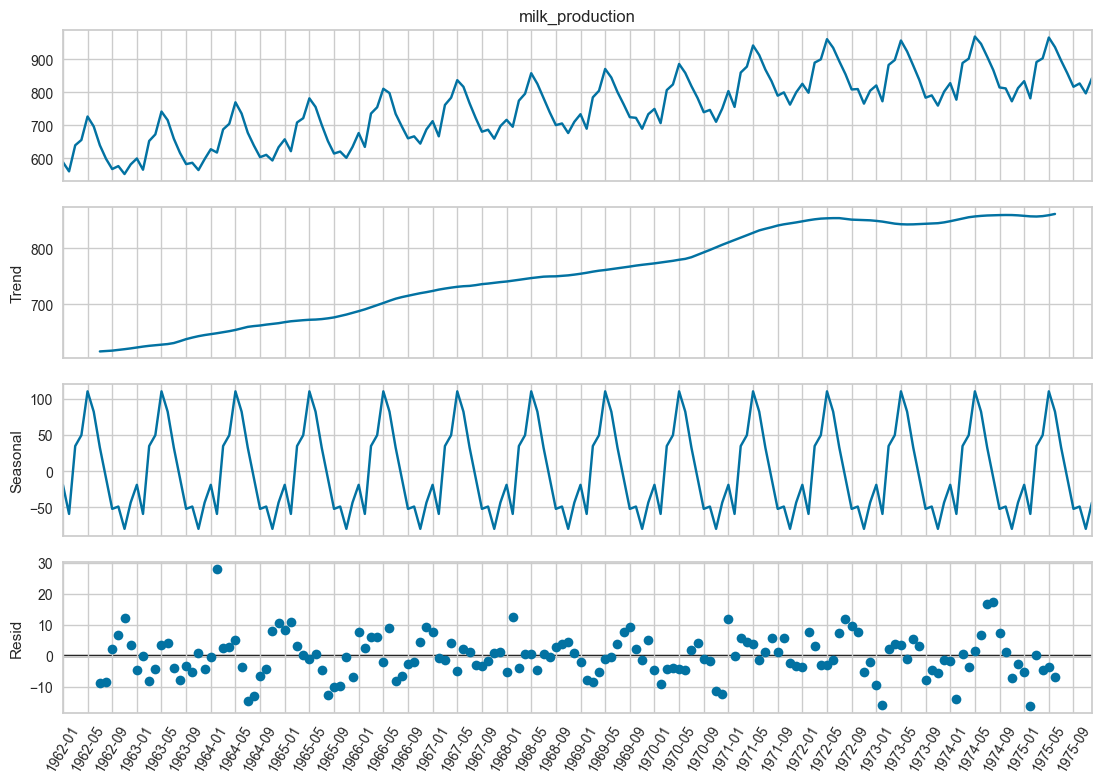

In [27]:
# Сезонная декомпозиция
decomposition = seasonal_decompose(df["milk_production"], period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.xticks(
    df.index[::4],
    rotation=60,
)
plt.show()

- Чётко виден тренд на увеличение производства
- Сезонность повторяется по годам
- Остатки не имеют выраженной зависимости от времени

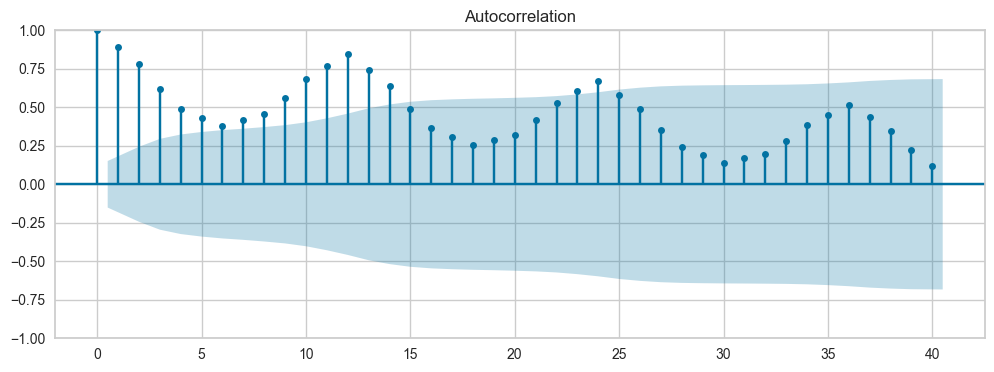

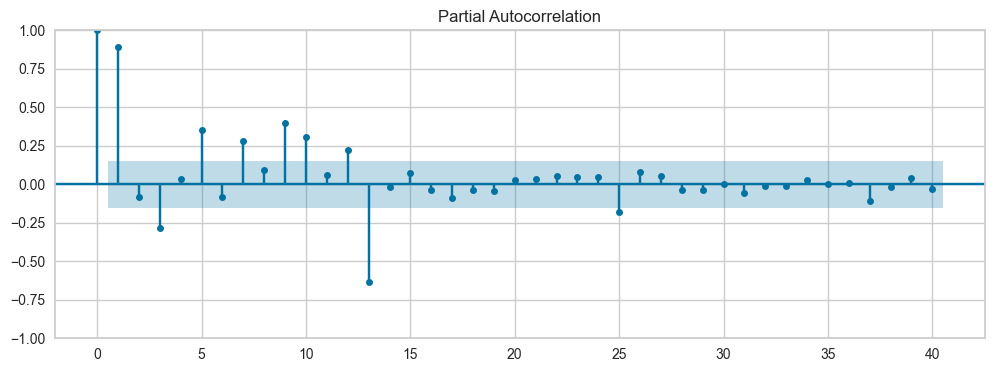

In [28]:
# Автокорреляция
plt.figure(figsize=(12, 4))
plot_acf(df["milk_production"], lags=40, ax=plt.gca())
plt.show()

# Частичная автокорреляция
plt.figure(figsize=(12, 4))
plot_pacf(df["milk_production"], lags=40, ax=plt.gca())
plt.show()

- ACF показывает медленное затухание, что свидетельствует о наличии выраженного тренда и сезонности
- Присутствуют заметные пики на лагах, кратных 12, что говорит о сезонности (12 месяцев)

## Применение инструментов AutoML

In [29]:
test_ratio = 0.2

train = df.iloc[: -int(len(df) * test_ratio)]
test = df.iloc[-int(len(df) * test_ratio) :]

print("Размер train:", train.shape)
print("Размер test:", test.shape)

Размер train: (135, 1)
Размер test: (33, 1)


In [30]:
 # Инициализация PyCaret
ts = setup(train.reset_index(), target="milk_production", index="Month", session_id=RANDOM_STATE)

,Description,Value
0,session_id,777
1,Target,milk_production
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(135, 1)"
5,Transformed data shape,"(135, 1)"
6,Transformed train set shape,"(134, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [31]:
# Подбор моделей
best_model = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.3746,0.3251,8.9339,8.9339,0.0113,0.0112,0.0900
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.3851,0.3345,9.1984,9.1984,0.0116,0.0115,0.0867
theta,Theta Forecaster,0.3900,0.3389,9.3327,9.3327,0.0116,0.0115,0.0233
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.4046,0.3513,9.6568,9.6568,0.0122,0.0121,0.1600
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.4047,0.3513,9.6585,9.6585,0.0122,0.0121,0.1433
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.4053,0.3519,9.6760,9.6760,0.0122,0.0121,0.1100
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.4058,0.3523,9.6826,9.6826,0.0122,0.0121,0.0400
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.4181,0.3630,9.9780,9.9780,0.0126,0.0125,0.1567
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.4232,0.3675,10.1013,10.1013,0.0127,0.0126,0.0333
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.4232,0.3674,10.0972,10.0972,0.0127,0.0126,0.0400


Лучшая модель комбинация Random Forest с автоматической обработкой временных закономерностей (тренд + сезонность).

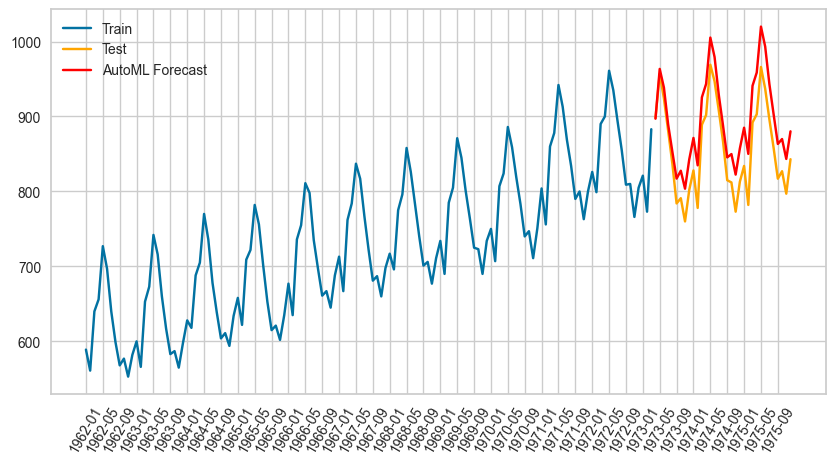

RMSE AutoML: 40.94


In [32]:
# Прогноз
forecast_aml = predict_model(best_model, fh=len(test) + 1)
forecast_aml = forecast_aml.iloc[1:, :]

forecast_aml.index = forecast_aml.index.to_timestamp()
forecast_aml.index = forecast_aml.index.strftime("%Y-%m")
forecast_aml.index.names = ["Month"]

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(train["milk_production"], label="Train")
plt.plot(test["milk_production"], label="Test", color="orange")
plt.plot(forecast_aml["y_pred"], label="AutoML Forecast", color="red")
plt.xticks(
    df.index[::4],
    rotation=60,
)
plt.legend()
plt.show()

# Оценка
rmse_aml = root_mean_squared_error(test["milk_production"], forecast_aml).round(2)
print("RMSE AutoML:", rmse_aml)

Модель AutoML демострирует меньшую точность по-сравнению с проведенными ранее экспериментами, в которых модель SARIMA имела RMSE=15.05

In [33]:
# Сохранение модели
save_model(best_model, 'ts_aml_model')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [12,
                                                                                                                                         11,
                                                                                                                                         10,
                                                                                                                                         9,
                                                                                                                                         8,
                                                                                                                                         7,
                                        